# NLP & W2VEC

In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import matplotlib.pyplot as plt
import json

from wordcloud import WordCloud
from pythainlp.tokenize import THAI2FIT_TOKENIZER # ใช้ในการตัดคำ
from pythainlp.corpus import common # ใช้ลบคำที่ไม่ใช้ออก

from sklearn import preprocessing

# Word2Vec
from pythainlp.word_vector import WordVector
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# AI
from sklearn.model_selection import train_test_split # split data set
from sklearn.metrics import accuracy_score, classification_report # report train & test result

# AI Models
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter Tunning
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from skopt.plots import plot_objective, plot_histogram

# Saving Intelligence
from joblib import dump, load


KeyboardInterrupt: 

In [ ]:
data = pd.read_csv("./data/data1668154807.csv")
data = data[['message', 'category']]

In [ ]:
data.head()

,message,category
0,ทำเองทุกข้อนะ,A
1,ใช่ที่ยิมส่งไปอันแรกเป็นแบบทดสอบ อันที่2 แบบปร...,A
2,อันที่ยิมส่งมาป่าว,A
3,ข้อ4ยังไม่ถูกทีนะ,A
4,เพราะ avr ต้องใช้เวลาศึกษา,A


### Data Features and Values

In [ ]:
def clean_data(data):
    # filter common chat
    # data = data.drop(data.index[ data['category'] == 'C' ])
    # sort data by category
    data = data.sort_values(by=['category'])

    data = data.reset_index()
    data = data[['message', 'category']]

    return data

In [ ]:
data = clean_data(data)

In [ ]:
category_list = data['category'].unique()
category_list

array(['A', 'C', 'Q', 'S', 'T'], dtype=object)

In [ ]:
data.shape

(13384, 2)

In [ ]:
data.dtypes

message     object
category    object
dtype: object

In [ ]:
data.isnull().any()

message     False
category    False
dtype: bool

### Countplot of target Variable(Category)

In [ ]:
def plot_count_graph():
    count_graph = sns.countplot(data.category)
    count_list = []

    for p in count_graph.patches:
        height = p.get_height()
        count_list.append(height)
        count_graph.annotate('{:.1f}'.format(height), (p.get_x()+0.25, height+0.01))

    plt.show()

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


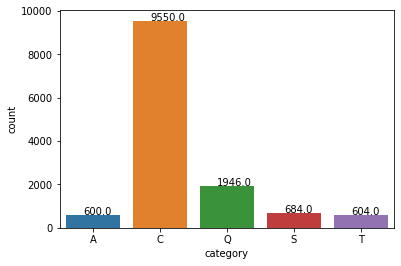

In [ ]:
plot_count_graph()

### Balancing Category

In [ ]:
df_list = []
for category in category_list:
    df_list.append(data.query(f"category == '{category}'").sample(
        n=600,
        replace=False, #True if numbers of sample higher than minimum numbers of category
        random_state=18, 
        )
    )

data = clean_data(data= pd.concat(df_list))

c:\Users\racha\dev\project_experiment\first_classification\exenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


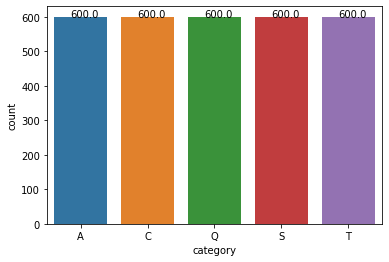

In [ ]:
plot_count_graph()

In [ ]:
data['message_length'] = data['message'].str.len()
print(data['message_length'])

0       30
1       17
2       21
3       75
4       18
        ..
2995    26
2996    42
2997    39
2998    22
2999    41
Name: message_length, Length: 3000, dtype: int64


### Words Distribution Plot

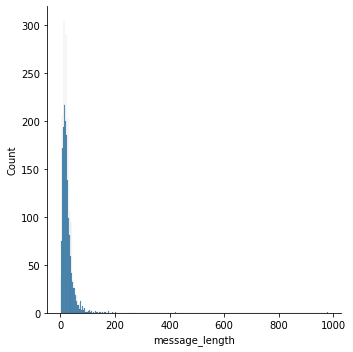

In [ ]:
sns.displot(data['message_length']).set_titles('message_length')

### Count Words

In [ ]:
def count_words(category=''):
    word_list = set()
    if(category != ''):
        sub_frame = data[data['category']==category]
    else:
        sub_frame = data

    for text in sub_frame['message']:
        
        text = text.lower().replace('\n', ' ').replace('\r', '').strip()
        text = re.findall(r"[\u0E00-\u0E7Fa-zA-Z']+", text)
        text = ' '.join(text)

        word_tokens = THAI2FIT_TOKENIZER.word_tokenize(text)
        filtered_sentence = set([w for w in word_tokens])

        word_list.update(filtered_sentence)

    return len(word_list)

In [ ]:
words_category = []
for category in category_list:
    words_category.append(count_words(category))

words_category

[997, 1140, 964, 925, 923]

In [ ]:
print('Total Word:')
print(count_words())

Total Word:
2645


<AxesSubplot:xlabel='category', ylabel='words_count'>

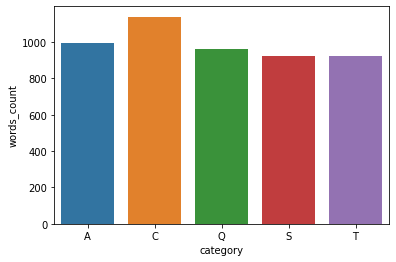

In [ ]:
words_count = {'category': category_list, 'words_count': words_category}
w_count_data = pd.DataFrame(words_count)
sns.barplot(x= 'category', y='words_count', data=w_count_data)

### Word Cloud

In [ ]:
def create_wordcloud(words):
    wordcloud = WordCloud(font_path='THSarabun.ttf', # path ที่ตั้ง Font
                      regexp=r"[\u0E00-\u0E7Fa-zA-Z']+" # ป้องกัน bug วรรณยุกต์
                      ).generate(' '.join(THAI2FIT_TOKENIZER.word_tokenize(words)))
    plt.figure(figsize=[10, 7])
    plt.imshow(wordcloud, interpolation= "bilinear")
    plt.axis('off')
    plt.show()

In [ ]:
def check_wordcloud(category):
    subset = data[data.category==category]
    text = subset.message.values
    words = ''.join(text)
    create_wordcloud(words)

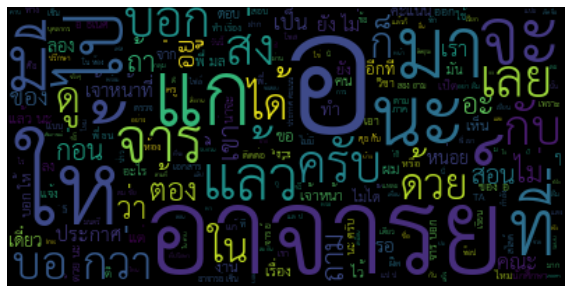

In [ ]:
check_wordcloud('T')

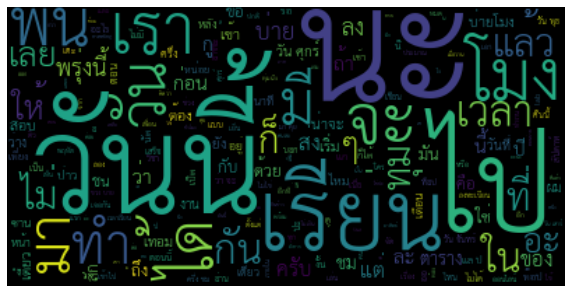

In [ ]:
check_wordcloud('S')

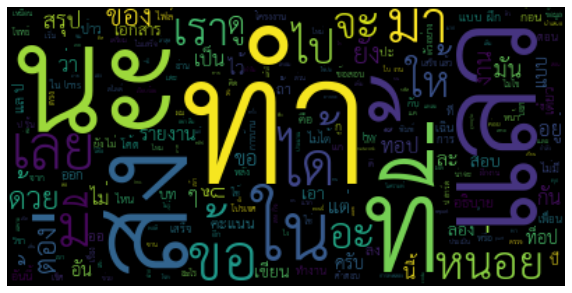

In [ ]:
check_wordcloud('A')

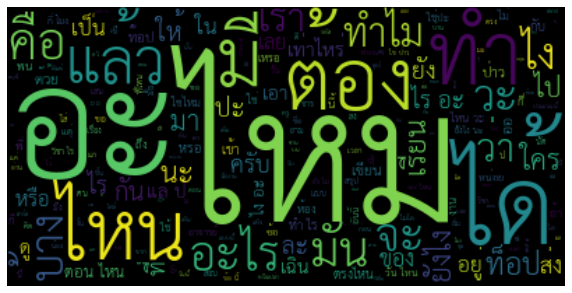

In [ ]:
check_wordcloud('Q')

### Label Encoding

In [ ]:
label_encoder = preprocessing.LabelEncoder()
data['category_target'] = label_encoder.fit_transform(data['category'])

In [ ]:
temp_data = data[['category', 'category_target']].drop_duplicates()
print(temp_data)


     category  category_target
0           A                0
600         C                1
1200        Q                2
1800        S                3
2400        T                4


In [ ]:
# keep category target in json
json_classes = temp_data.to_json(orient="records")
json_file = 'classes.json'

# Writing to .json
with open(json_file, "w") as outfile:
    outfile.write(json_classes)


   


In [ ]:
# Opening JSON file
with open(json_file, 'r') as openfile:
    # Reading from json file
    temp_json = json.load(openfile)
    print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [ ]:
temp_json.sort(key=lambda item : item['category_target'])
print(temp_json)

[{'category': 'A', 'category_target': 0}, {'category': 'C', 'category_target': 1}, {'category': 'Q', 'category_target': 2}, {'category': 'S', 'category_target': 3}, {'category': 'T', 'category_target': 4}]


In [ ]:
classes_list = [ item['category'] for item in temp_json]
print(classes_list)

['A', 'C', 'Q', 'S', 'T']


### Word2Vec

In [ ]:
w2v_thai = WordVector()

In [ ]:

word2vec = [w2v_thai.sentence_vectorizer(data['message'][i]) 
            for i in range(0,len(data['message']))]

In [ ]:
X = np.array(word2vec).tolist()

data['word2vec'] = X
data_reshape = np.reshape(X, (-1, 300))

In [ ]:
print(data_reshape.shape)

(3000, 300)


In [ ]:
data.head()

,message,category,message_length,category_target,word2vec
0,รายละเอียดที่จะออกสอบ ไม่รู้อะ,A,30,0,"[[-0.12202585594994682, -0.07878928485193423, ..."
1,ทำโจทเฉยๆเมื่อกี้,A,17,0,"[[-0.16262699216604232, -0.175881202891469, 0...."
2,ทำความเข้าใจโจทย์อยู่,A,21,0,"[[-0.05067133468886217, 0.05846833437681198, 0..."
3,น้องบีรพี่ขอโพสปี1กิจกรรมเจอพี่รหัสหน่อย พี่ว่...,A,75,0,"[[-0.07430555646307767, -0.1286204032972455, 0..."
4,อันที่ยิมส่งมาป่าว,A,18,0,"[[-0.04463533513868848, 0.11442433980604012, 0..."


# AI MODEL

### Split the data in Training and Testing

In [ ]:
data_temp = [ x for x in data['word2vec']]
data_reshape = np.reshape(data_temp, (-1, 300))
data_reshape.shape


(3000, 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_reshape,
                                                    data['category_target'],
                                                    random_state=18,
                                                    test_size = 0.2,
                                                    shuffle=True
                                                    )

In [ ]:
print(X_train.shape)
print(y_train.shape)

(2400, 300)
(2400,)


In [ ]:
print(X_test.shape)
print(y_test.shape)

(600, 300)
(600,)


### Models Predictions

In [ ]:
# RandomForest Model
rf_model = RandomForestClassifier(
    # n_estimators= 1300,
    # max_depth= 180,
    # min_samples_split= 2,
    # bootstrap= False,
    # criterion= 'entropy',
    )
rf_model.fit(X_train, y_train)

accuracy_predictions = rf_model.predict(X_train)
print('Validation', accuracy_score(y_train, accuracy_predictions))

model_predictions = rf_model.predict(X_test)
print('Accuracy', accuracy_score(y_test, model_predictions))

print(classification_report(y_test, model_predictions))

Validation 0.9995833333333334
Accuracy 0.6166666666666667
              precision    recall  f1-score   support

           0       0.43      0.58      0.50       112
           1       0.67      0.42      0.51       129
           2       0.52      0.56      0.54       110
           3       0.71      0.68      0.69       116
           4       0.80      0.83      0.81       133

    accuracy                           0.62       600
   macro avg       0.62      0.61      0.61       600
weighted avg       0.63      0.62      0.62       600



### Load Saved Model

In [ ]:
# rf_model = load('./models/rf_model.joblib') 

In [ ]:
# accuracy_predictions = rf_model.predict(X_train)
# print('Validation', accuracy_score(y_train, accuracy_predictions))

# model_predictions = rf_model.predict(X_test)
# print('Accuracy', accuracy_score(y_test, model_predictions))

# print(classification_report(y_test, model_predictions))

### Save AI Model

In [ ]:
# dump(rf_model, './models/rf_model.joblib')

### BayesSearch Hyperparameter Tunning

<!-- Suggest Config RandomForest example
{'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
        2378, 2585, 2792, 3000]),
 'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
 'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
 'min_samples_leaf': [1, 2, 3, 4],
 'bootstrap': [True, False],
 'criterion': ['gini', 'entropy']} -->

In [ ]:
# model = RandomForestClassifier(
#     # bootstrap=False,
#     # criterion='entropy',
#     # min_samples_split=2,
#     )
# opt = BayesSearchCV(
#     model,
#     {
#         'n_estimators': Integer(800, 1500),
#         'max_depth': Integer(100, 200),
#         'min_samples_split': Integer(2, 30),
#         'min_samples_leaf': Integer(1, 10),
#         'bootstrap': Categorical(['True', 'False']),
#         'criterion': Categorical(['gini', 'entropy']),
#     }
#     , cv=3
#     , verbose=1
#     , random_state=0
#     , n_iter= 100
# )
# opt.fit(X_train, y_train)

In [ ]:
# print(opt.best_score_)
# print(opt.best_params_)

In [ ]:
# plot_objective(opt.optimizer_results_[0],
#                    dimensions=[
#                     'bootstrap',
#                     'criterion',
#                     'max_depth',
#                     'min_samples_leaf',
#                     'min_samples_split',
#                     'n_estimator',
#                     # 'random_state',
#                     ],
#                    n_minimum_search=int(1e8))
# plt.show()

# Use Case with Modules


In [1]:
from project_module.message_classifier import MessageClassifier

In [2]:
message_classifier = MessageClassifier(error_sd= 0.07765331184188104)

In [3]:
message_classifier.load_model(model_path='./models/rf_model.joblib', json_classes_path='./classes.json')

In [5]:
print(message_classifier.classify(text_input='ว่ายังไง'))

[0.06957010852370435]
['Q', 0.32]


### Analyz Model

In [ ]:
result_data = pd.DataFrame(y_test.reset_index())

result_data['message'] = [ data.loc[i]['message'] for i in result_data['index'] ]
result_data['predict'] = message_classifier.predict(X_test)
result_data['predict_proba'] = [ p for p in message_classifier.predict_proba(X_test) ]
result_data['predict_sd'] = message_classifier.predict_sd(X_test)
result_data.head()


NameError: name 'pd' is not defined

In [ ]:
temp = result_data.drop(result_data.index[ result_data['category_target'] == result_data['predict'] ])
temp.head()

mean_error_sd =  temp['predict_sd'].mean()
print(f'avg sd of wrong predict: {mean_error_sd}')


avg sd of wrong predict: 0.07765331184188104


### Summary Final Result

['A', 'C', 'Q', 'S', 'T']

In [ ]:
def count_category(data):
    count = [0, 0, 0, 0, 0]
    
    for y in data:
        count[y] += 1
    
    return count

In [ ]:
y_result =  message_classifier.v_classify(X_test)


AttributeError: 'MessageClassifier' object has no attribute 'v_classify'

In [ ]:
y_test.count()

600

In [ ]:
test_count = count_category(y_test)
test_count

[112, 129, 110, 116, 133]

In [ ]:
result_count = count_category(y_result)
result_count

[152, 101, 106, 106, 135]

In [ ]:
print('Accuracy', accuracy_score(y_test, y_result))

print(classification_report(y_test, y_result))

Accuracy 0.62
              precision    recall  f1-score   support

           0       0.46      0.62      0.53       112
           1       0.55      0.43      0.49       129
           2       0.60      0.58      0.59       110
           3       0.68      0.62      0.65       116
           4       0.81      0.83      0.82       133

    accuracy                           0.62       600
   macro avg       0.62      0.62      0.62       600
weighted avg       0.63      0.62      0.62       600



In [ ]:
temp = [0, 0, 0, 0, 0]

for i in range(5):
    print(i)
    temp[i] = 1 - (abs(result_count[i] - test_count[i]) / test_count[i])

print(f'Test Accuray: {temp}')
print(f'Avg: {sum(temp) / len(temp)}')

0
1
2
3
4
Test Accuray: [0.6428571428571428, 0.7829457364341086, 0.9636363636363636, 0.9137931034482758, 0.9849624060150376]
Avg: 0.8576389504781858
